#Assignment Part 1 '**Classification**'

In 1st part of assignment you are requied to implement a classifier. The given links provide examples of a classification model for MNIST handwritten digits (0-9). You can refer to the provided links for guidance.
1. https://github.com/RafayKhattak/Digit-Classification-Pytorch/tree/main
2. https://github.com/jkotra/mnist-pytorch

# **Task 1**: 30 Marks

Now your task is to implement a PyTorch model for classifying 36 characters, including digits (0-9) and alphabets (A-Z), using the dataset provided in the CNN_dataset folder.

In [42]:
# Load libraries

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torchvision import datasets
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report

In [30]:
# Set the device (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define transformations for the dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5),  (0.5, 0.5, 0.5))])

In [31]:
def get_num_params(model: nn.Module):
    '''Returns the number of parameters in a PyTorch model'''
    return sum(p.numel() for p in model.parameters())

In [32]:
# Load dataset and prepare dataloaders

train_dir = 'CNN_dataset/train'
val_dir = 'CNN_dataset/val'


train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")
print(f"Classes: {train_dataset.classes}")

Number of training samples: 1903
Number of validation samples: 458
Number of classes: 36
Classes: ['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9', 'class_A', 'class_B', 'class_C', 'class_D', 'class_E', 'class_F', 'class_G', 'class_H', 'class_I', 'class_J', 'class_K', 'class_L', 'class_M', 'class_N', 'class_O', 'class_P', 'class_Q', 'class_R', 'class_S', 'class_T', 'class_U', 'class_V', 'class_W', 'class_X', 'class_Y', 'class_Z']


In [33]:
# Function to remove 'class_' prefix from class names

def rename_classes(dataset):

    new_classes = [cls.replace('class_', '') for cls in dataset.classes]
    dataset.classes = new_classes
    dataset.class_to_idx = {cls: idx for idx, cls in enumerate(dataset.classes)}
    
    return dataset


train_dataset = rename_classes(train_dataset)
val_dataset = rename_classes(val_dataset)


print("Updated Classes in Training Dataset:")
print(train_dataset.classes)

print("\nUpdated Classes in Validation Dataset:")
print(val_dataset.classes)


Updated Classes in Training Dataset:
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

Updated Classes in Validation Dataset:
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


Label (Class Index): 4 (4)


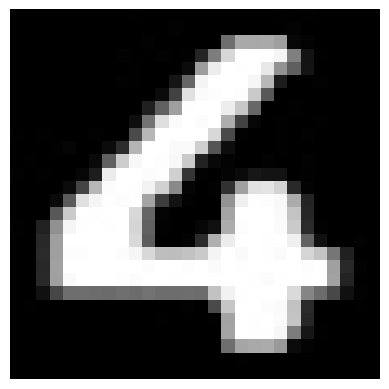

Image Dimensions: torch.Size([3, 28, 28])


In [34]:
def imshow(img):
    img = img * 0.5 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # Hide axis
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

random_idx = random.randint(0, images.size(0) - 1)
random_image = images[random_idx]
random_label = labels[random_idx]

print(f"Label (Class Index): {random_label} ({train_dataset.classes[random_label]})")
imshow(random_image)

print(f"Image Dimensions: {random_image.shape}")  # Should be [3, 28, 28] for RGB images


In [35]:

# Define the CNN model
class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)   # Output: 64 x 28 x 28
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1) # Output: 128 x 14 x 14
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1) # Output: 256 x 7 x 7

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 3 * 3, 1024)  # Adjusted input size based on pooling
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 36)  # 36 classes (0-9 and A-Z)

        # Activation function
        self.relu = nn.ReLU()
        
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):

        x = self.relu(self.conv1(x))  # [64, 28, 28]
        x = self.pool(x)              # [64, 14, 14]

        x = self.relu(self.conv2(x))  # [128, 14, 14]
        x = self.pool(x)              # [128, 7, 7]

        x = self.relu(self.conv3(x))  # [256, 7, 7]
        x = self.pool(x)              # [256, 3, 3]

        x = x.view(x.size(0), -1)     # [256*3*3 = 2304]

        x = self.relu(self.fc1(x))    # [1024]
        x = self.dropout(x)            # Apply dropout

        x = self.relu(self.fc2(x))    # [512]
        x = self.dropout(x)            # Apply dropout

        x = self.fc3(x)                # [36]

        return x


# Example model instance
model = CNNNet()
print(model)
print(f"Model has {get_num_params(model)} parameters.")

CNNNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2304, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=36, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)
Model has 3274404 parameters.


In [36]:
# Initialize the model, loss function, and optimizer

criterion = nn.CrossEntropyLoss()
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []
all_val_preds = []
all_val_targets = []

In [37]:
def train(model, device, train_loader, optimizer, criterion, epoch, train_losses):
    
    model.train()  
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(train_loader):

        data, target = data.to(device), target.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(data)

        # Compute the loss
        loss = criterion(outputs, target)

        # Backpropagation
        loss.backward()

        # Update the weights
        optimizer.step()

        running_loss += loss.item()

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}'
                  f' ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    average_loss = running_loss / len(train_loader)
    train_losses.append(average_loss)
    print(f'====> Epoch: {epoch} Average Training Loss: {average_loss:.4f}')


In [38]:
def test(model, device, test_loader, criterion, val_losses):
    model.eval()
    test_loss = 0.0
    correct = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():  

        for data, target in test_loader:

            data, target = data.to(device), target.to(device)

            # Forward pass
            outputs = model(data)

            # Compute the loss
            loss = criterion(outputs, target)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    # Calculate average loss and accuracy
    average_loss = test_loss / len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    val_losses.append(average_loss)

    print(f'\nTest set: Average loss: {average_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)}'
          f' ({accuracy:.0f}%)\n')

    return all_preds, all_targets

In [39]:
n_epochs = 5

for epoch in range(1, n_epochs + 1):
    
    print(f"Epoch {epoch}/{n_epochs}")
    
    train(model, device, train_loader, optimizer, criterion, epoch, train_losses)
    
    val_preds, val_targets = test(model, device, val_loader, criterion, val_losses)
    all_val_preds = val_preds
    all_val_targets = val_targets
    
    print('-' * 50)  

Epoch 1/5
Train Epoch: 1 [0/1903 (0%)]	Loss: 3.592621
====> Epoch: 1 Average Training Loss: 3.0516

Test set: Average loss: 1.8713, Accuracy: 265/458 (58%)

--------------------------------------------------
Epoch 2/5
Train Epoch: 2 [0/1903 (0%)]	Loss: 1.695870
====> Epoch: 2 Average Training Loss: 1.0304

Test set: Average loss: 0.2467, Accuracy: 432/458 (94%)

--------------------------------------------------
Epoch 3/5
Train Epoch: 3 [0/1903 (0%)]	Loss: 0.409838
====> Epoch: 3 Average Training Loss: 0.3473

Test set: Average loss: 0.1361, Accuracy: 439/458 (96%)

--------------------------------------------------
Epoch 4/5
Train Epoch: 4 [0/1903 (0%)]	Loss: 0.294564
====> Epoch: 4 Average Training Loss: 0.1875

Test set: Average loss: 0.1562, Accuracy: 444/458 (97%)

--------------------------------------------------
Epoch 5/5
Train Epoch: 5 [0/1903 (0%)]	Loss: 0.240910
====> Epoch: 5 Average Training Loss: 0.1565

Test set: Average loss: 0.0753, Accuracy: 450/458 (98%)

-----------

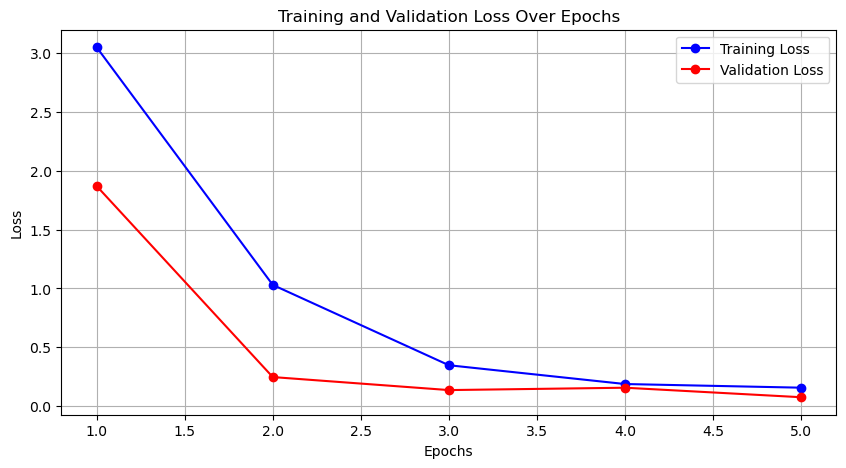

In [40]:
def plot_loss_curves(train_losses, val_losses, n_epochs):
    """
    Plots the training and validation loss curves.

    Parameters:
    - train_losses (list): List of average training losses per epoch.
    - val_losses (list): List of average validation losses per epoch.
    - n_epochs (int): Number of epochs.
    """
    epochs = range(1, n_epochs + 1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')  # 'bo-' means blue dots with solid line
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')  # 'ro-' means red dots with solid line
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss_curves(train_losses, val_losses, 5)

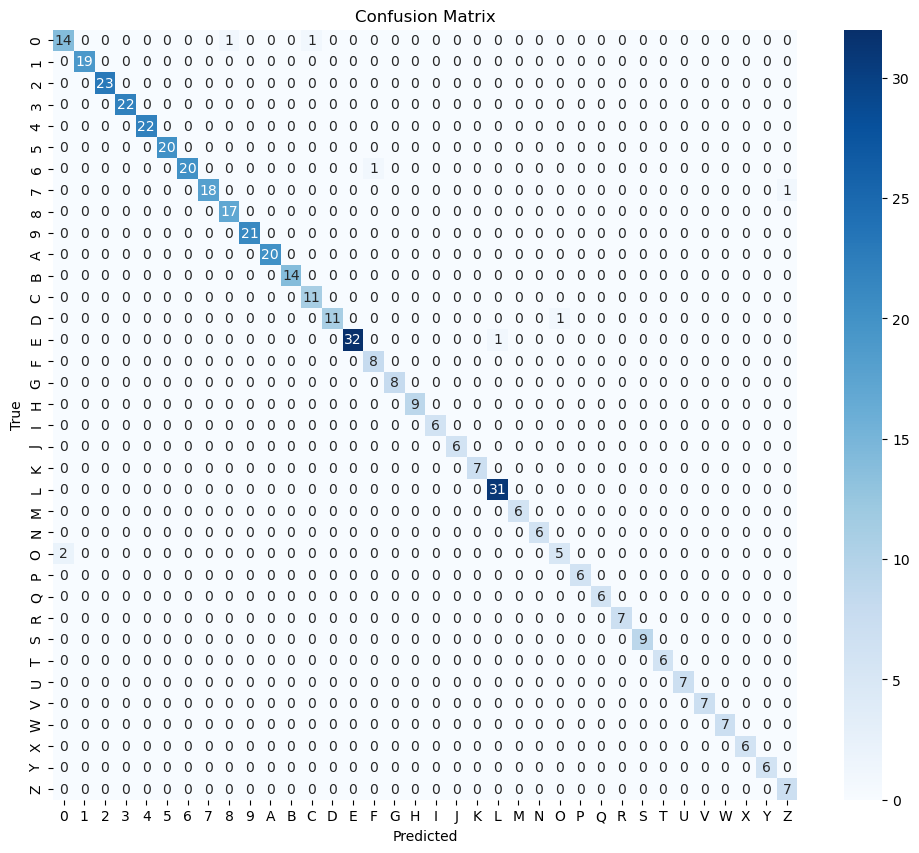

Precision: 98.06%
Recall: 98.26%
F1 Score: 98.11%


In [41]:
cm = confusion_matrix(all_val_targets, all_val_preds)

class_names = train_dataset.classes  

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

precision, recall, f1, _ = precision_recall_fscore_support(all_val_targets, all_val_preds, average='macro')

print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')

In [43]:
report = classification_report(all_val_targets, all_val_preds, target_names=train_dataset.classes)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.88      0.88        16
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        23
           3       1.00      1.00      1.00        22
           4       1.00      1.00      1.00        22
           5       1.00      1.00      1.00        20
           6       1.00      0.95      0.98        21
           7       1.00      0.95      0.97        19
           8       0.94      1.00      0.97        17
           9       1.00      1.00      1.00        21
           A       1.00      1.00      1.00        20
           B       1.00      1.00      1.00        14
           C       0.92      1.00      0.96        11
           D       1.00      0.92      0.96        12
           E       1.00      0.97      0.98        33
           F       0.89      1.00      0.94         8
           G       1.00      1.00      1.00         8
           H       1.00    

In [44]:
model_save_path = 'cnn_model_state_dict.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model's state_dict has been saved to {model_save_path}")

Model's state_dict has been saved to cnn_model_state_dict.pth


In [45]:
model_save_path = 'cnn.pth'
torch.save(model, model_save_path)
print(f"Entire model has been saved to {model_save_path}")

Entire model has been saved to cnn.pth


# **Task 2:** 20 Marks
Repeat Task 1 but this time your model trainable parameters should less than 1 Million.

In [57]:
class BottleneckCNN(nn.Module):
    def __init__(self):
        super(BottleneckCNN, self).__init__()

        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # ---------------------------
        # Convolutional Layer 1
        # ---------------------------
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)  # Output: 64 x 28 x 28
        self.bn1 = nn.BatchNorm2d(64)

        # Bottleneck Block 1
        self.bottleneck1_reduce = nn.Conv2d(64, 32, kernel_size=1)  # Reduce channels from 64 to 32
        self.bottleneck1_bn_reduce = nn.BatchNorm2d(32)
        self.bottleneck1_conv = nn.Conv2d(32, 32, kernel_size=3, padding=1)  # 32 channels
        self.bottleneck1_bn_conv = nn.BatchNorm2d(32)
        self.bottleneck1_restore = nn.Conv2d(32, 64, kernel_size=1)  # Restore channels from 32 to 64
        self.bottleneck1_bn_restore = nn.BatchNorm2d(64)

        # ---------------------------
        # Convolutional Layer 2
        # ---------------------------
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)  # Output: 128 x 14 x 14
        self.bn2 = nn.BatchNorm2d(128)

        # Bottleneck Block 2
        self.bottleneck2_reduce = nn.Conv2d(128, 64, kernel_size=1)  # Reduce channels from 128 to 64
        self.bottleneck2_bn_reduce = nn.BatchNorm2d(64)
        self.bottleneck2_conv = nn.Conv2d(64, 64, kernel_size=3, padding=1)  # 64 channels
        self.bottleneck2_bn_conv = nn.BatchNorm2d(64)
        self.bottleneck2_restore = nn.Conv2d(64, 128, kernel_size=1)  # Restore channels from 64 to 128
        self.bottleneck2_bn_restore = nn.BatchNorm2d(128)

        # ---------------------------
        # Convolutional Layer 3
        # ---------------------------
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)  # Output: 256 x 7 x 7
        self.bn3 = nn.BatchNorm2d(256)

        # Bottleneck Block 3
        self.bottleneck3_reduce = nn.Conv2d(256, 128, kernel_size=1)  # Reduce channels from 256 to 128
        self.bottleneck3_bn_reduce = nn.BatchNorm2d(128)
        self.bottleneck3_conv = nn.Conv2d(128, 128, kernel_size=3, padding=1)  # 128 channels
        self.bottleneck3_bn_conv = nn.BatchNorm2d(128)
        self.bottleneck3_restore = nn.Conv2d(128, 256, kernel_size=1)  # Restore channels from 128 to 256
        self.bottleneck3_bn_restore = nn.BatchNorm2d(256)

        # ---------------------------
        # Global Average Pooling
        # ---------------------------
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # Output: 256 x 1 x 1

        # ---------------------------
        # Fully Connected Layer
        # ---------------------------
        self.fc = nn.Linear(256, 36)  # 36 classes (0-9 and A-Z)

    def forward(self, x):
        # ---------------------------
        # Forward Pass through Conv1 and Bottleneck1
        # ---------------------------
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)  # [64, 14, 14]

        # Bottleneck Block 1
        residual = x
        bottleneck = self.bottleneck1_reduce(x)
        bottleneck = self.bottleneck1_bn_reduce(bottleneck)
        bottleneck = self.relu(bottleneck)
        bottleneck = self.bottleneck1_conv(bottleneck)
        bottleneck = self.bottleneck1_bn_conv(bottleneck)
        bottleneck = self.relu(bottleneck)
        bottleneck = self.bottleneck1_restore(bottleneck)
        bottleneck = self.bottleneck1_bn_restore(bottleneck)
        x = residual + bottleneck  # Residual Connection
        x = self.relu(x)

        # ---------------------------
        # Forward Pass through Conv2 and Bottleneck2
        # ---------------------------
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)  # [128, 7, 7]

        # Bottleneck Block 2
        residual = x
        bottleneck = self.bottleneck2_reduce(x)
        bottleneck = self.bottleneck2_bn_reduce(bottleneck)
        bottleneck = self.relu(bottleneck)
        bottleneck = self.bottleneck2_conv(bottleneck)
        bottleneck = self.bottleneck2_bn_conv(bottleneck)
        bottleneck = self.relu(bottleneck)
        bottleneck = self.bottleneck2_restore(bottleneck)
        bottleneck = self.bottleneck2_bn_restore(bottleneck)
        x = residual + bottleneck  # Residual Connection
        x = self.relu(x)

        # ---------------------------
        # Forward Pass through Conv3 and Bottleneck3
        # ---------------------------
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool(x)  # [256, 3, 3]

        # Bottleneck Block 3
        residual = x
        bottleneck = self.bottleneck3_reduce(x)
        bottleneck = self.bottleneck3_bn_reduce(bottleneck)
        bottleneck = self.relu(bottleneck)
        bottleneck = self.bottleneck3_conv(bottleneck)
        bottleneck = self.bottleneck3_bn_conv(bottleneck)
        bottleneck = self.relu(bottleneck)
        bottleneck = self.bottleneck3_restore(bottleneck)
        bottleneck = self.bottleneck3_bn_restore(bottleneck)
        x = residual + bottleneck  # Residual Connection
        x = self.relu(x)

        # ---------------------------
        # Global Average Pooling and Fully Connected Layer
        # ---------------------------
        x = self.global_avg_pool(x)  # [256, 1, 1]
        x = x.view(x.size(0), -1)    # [256]
        x = self.fc(x)                # [36]

        return x

bottleneck_cnn = BottleneckCNN()
print(bottleneck_cnn)
print(f"Model has {get_num_params(bottleneck_cnn):,} parameters.")


BottleneckCNN(
  (relu): ReLU(inplace=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bottleneck1_reduce): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (bottleneck1_bn_reduce): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bottleneck1_conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bottleneck1_bn_conv): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bottleneck1_restore): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
  (bottleneck1_bn_restore): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_r

In [58]:
train_losses_bcnn = []
val_losses_bcnn = []
all_val_preds_bcnn = []
all_val_targets_bcnn = []

bottleneck_cnn = bottleneck_cnn.to(device)
optimizer = optim.Adam(bottleneck_cnn.parameters(), lr=0.001)

Epoch 1/5
Train Epoch: 1 [0/1903 (0%)]	Loss: 3.939199
====> Epoch: 1 Average Training Loss: 1.4903

Test set: Average loss: 0.9811, Accuracy: 385/458 (84%)

--------------------------------------------------
Epoch 2/5
Train Epoch: 2 [0/1903 (0%)]	Loss: 0.341284
====> Epoch: 2 Average Training Loss: 0.2037

Test set: Average loss: 0.1428, Accuracy: 449/458 (98%)

--------------------------------------------------
Epoch 3/5
Train Epoch: 3 [0/1903 (0%)]	Loss: 0.077544
====> Epoch: 3 Average Training Loss: 0.0646

Test set: Average loss: 0.0680, Accuracy: 450/458 (98%)

--------------------------------------------------
Epoch 4/5
Train Epoch: 4 [0/1903 (0%)]	Loss: 0.023272
====> Epoch: 4 Average Training Loss: 0.0283

Test set: Average loss: 0.0398, Accuracy: 453/458 (99%)

--------------------------------------------------
Epoch 5/5
Train Epoch: 5 [0/1903 (0%)]	Loss: 0.009994
====> Epoch: 5 Average Training Loss: 0.0179

Test set: Average loss: 0.0397, Accuracy: 452/458 (99%)

-----------

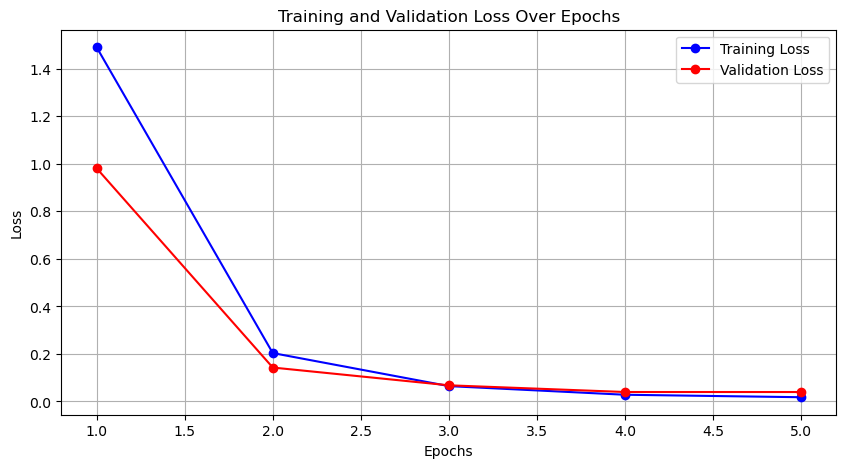

In [59]:
n_epochs = 5

for epoch in range(1, n_epochs + 1):
    
    print(f"Epoch {epoch}/{n_epochs}")
    
    train(bottleneck_cnn, device, train_loader, optimizer, criterion, epoch, train_losses_bcnn)
    
    val_preds, val_targets = test(bottleneck_cnn, device, val_loader, criterion, val_losses_bcnn)
    all_val_preds_bcnn = val_preds
    all_val_targets_bcnn = val_targets
    
    print('-' * 50)  

plot_loss_curves(train_losses_bcnn, val_losses_bcnn, 5)

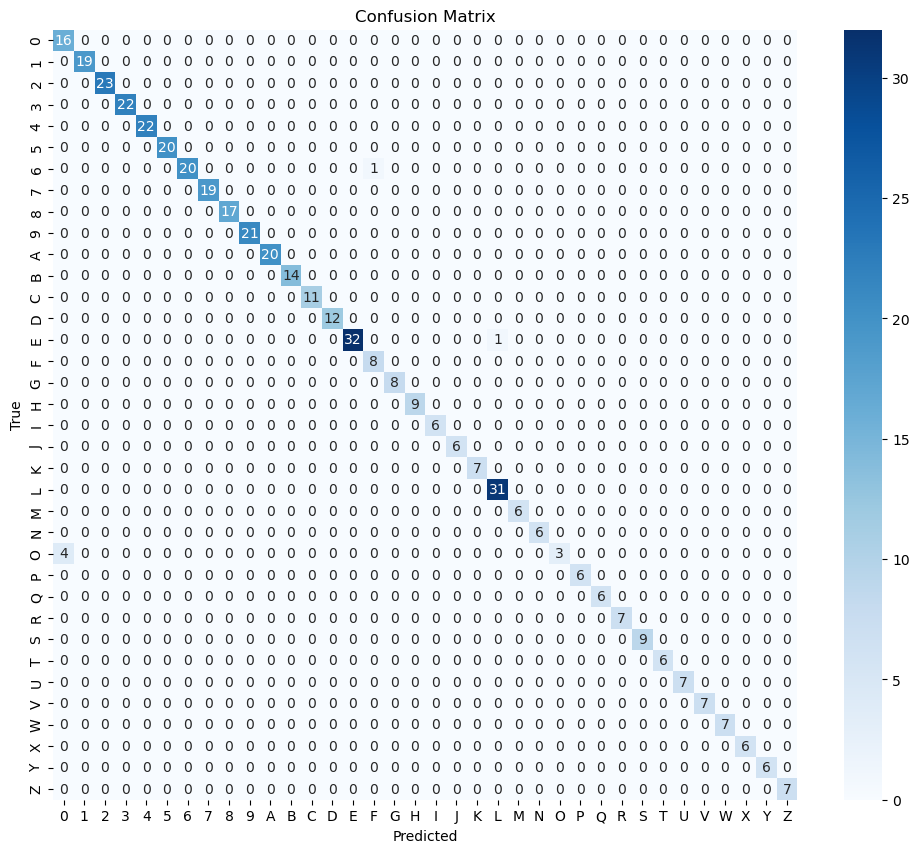

Precision: 99.05%
Recall: 98.20%
F1 Score: 98.26%


In [60]:
# show confusion matrix, calculate precision (P%), Recall (R%), and F1 Score (f1%)

cm = confusion_matrix(all_val_targets_bcnn, all_val_preds_bcnn)

class_names = train_dataset.classes  

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

precision, recall, f1, _ = precision_recall_fscore_support(all_val_targets_bcnn, all_val_preds_bcnn, average='macro')

print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')

In [61]:
report = classification_report(all_val_targets_bcnn, all_val_preds_bcnn, target_names=train_dataset.classes)
print(report)

              precision    recall  f1-score   support

           0       0.80      1.00      0.89        16
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        23
           3       1.00      1.00      1.00        22
           4       1.00      1.00      1.00        22
           5       1.00      1.00      1.00        20
           6       1.00      0.95      0.98        21
           7       1.00      1.00      1.00        19
           8       1.00      1.00      1.00        17
           9       1.00      1.00      1.00        21
           A       1.00      1.00      1.00        20
           B       1.00      1.00      1.00        14
           C       1.00      1.00      1.00        11
           D       1.00      1.00      1.00        12
           E       1.00      0.97      0.98        33
           F       0.89      1.00      0.94         8
           G       1.00      1.00      1.00         8
           H       1.00    

In [62]:
bcnn_save_path = 'bcnn_model_state_dict.pth'
torch.save(bottleneck_cnn.state_dict(), bcnn_save_path)
print(f"Bottleneck CNN Model's state_dict has been saved to {bcnn_save_path}")

Bottleneck CNN Model's state_dict has been saved to bcnn_model_state_dict.pth


In [63]:
bcnn_model_save_path = 'bottleneck_cnn.pth'
torch.save(model, bcnn_model_save_path)
print(f"Bottleneck CNN model has been saved to {bcnn_model_save_path}")

Bottleneck CNN model has been saved to bottleneck_cnn.pth


Great job! Now you have completed 1st part of you assignment. Hurrey!






